In [1]:
import numpy as np
import neural_network
import neural_net_optimized
import matplotlib.pyplot as plt
from lr_utils import load_dataset
from sklearn.metrics import accuracy_score

# Set the default size for plots
plt.rcParams.update({'figure.figsize': (4, 4)})

In [2]:
# Load data.
train_x_orig, train_y, test_x_orig, test_y = load_dataset()

In [3]:
train_x_orig_shape = train_x_orig.shape
train_y_shape = train_y.shape
test_x_orig_shape = test_x_orig.shape
test_y_shape = test_y.shape

print(f"train_x_orig shape: {train_x_orig.shape} \ntrain_y shape: {train_y.shape} \ntest_x_orig shape: {test_x_orig.shape} \ntest_y shape: {test_y.shape}")

train_x_orig shape: (209, 64, 64, 3) 
train_y shape: (1, 209) 
test_x_orig shape: (50, 64, 64, 3) 
test_y shape: (1, 50)


In [4]:
# Reshape the training array such that each column represents an image
train_x_orig_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_orig_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

print(f"shape of train_x_orig_flatten = {train_x_orig_flatten.shape}, \nshape of test_x_orig_flatten = {test_x_orig_flatten.shape}")

shape of train_x_orig_flatten = (12288, 209), 
shape of test_x_orig_flatten = (12288, 50)


In [5]:
# Since pixel values are between 0 and 255, dividing by 255 will rescale their values to be between 0 and 1
train_X = train_x_orig_flatten/255.
test_X = test_x_orig_flatten/255.

print(f"Shape of train_X: {train_X.shape} \nShape of test_X: {test_X.shape}")

Shape of train_X: (12288, 209) 
Shape of test_X: (12288, 50)


In [6]:
# Let us build 2 NN's, a 2-layer NN and an L-layer NN, and compare their performances
def neural_network_blueprint(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1) # Define np seed for reproducible results

    NN = neural_network.NeuralNet(layers_dims) # Create NN instance, which initializes parameters.

    costs = [] # Collection of costs for plotting

    # Repeat forward prop, back prop, and gradient descent num_iterations times.
    for i in range(num_iterations):

        # Extract prediction from forward prop and caches from each layer.
        AL, caches = NN.forward_propagation(X)

        # Use the prediction to compute the cost
        cost = NN.compute_cost(AL, Y)

        # Perform back prop, initializing it with AL and Y.
        grads = NN.backward_propagation(AL, Y, caches)

        # Update parameter using gradient descent.
        NN.update_parameters(grads, learning_rate)

        # Append cost to costs array for each iteration
        costs.append(cost)

        # Print cost per 500 iterations and for last iteration if print_cost is true
        if (i % 500 == 0 or i == num_iterations - 1) and print_cost == True:
            print(f"Cost after iteration {i}: {cost}")

    return costs, NN

# Define structure for the 2-layer NN.
layers_dims = [12288, 7, 1]
costs, two_layer_NN = neural_network_blueprint(train_X, train_y, layers_dims, print_cost = True)

Cost after iteration 0: 0.7074426632736273
Cost after iteration 500: 0.3336897138438556
Cost after iteration 1000: 0.12412486168658173
Cost after iteration 1500: 0.05362667055856123
Cost after iteration 2000: 0.03330274414524972
Cost after iteration 2500: 0.02306424025583977
Cost after iteration 2999: 0.016151946179173104


2 layer NN: 
Accuracy_train: 100.00% 
Accuracy_test: 74.00%


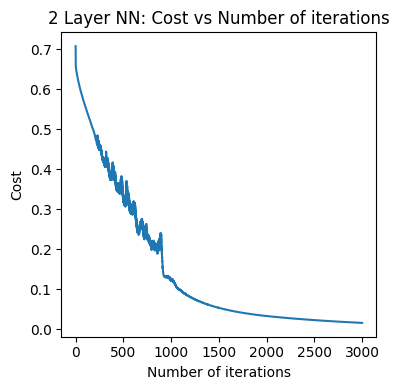

In [7]:
# Predictions for train and test with the two layer NN.
predictions_train = two_layer_NN.predict(train_X)
predictions_test = two_layer_NN.predict(test_X)

# Select the first row of each array to make them 1D. Calculate accuracy for 2 layer NN
accuracy_train = accuracy_score(predictions_train[0], train_y[0])
accuracy_test = accuracy_score(predictions_test[0], test_y[0])
print(f"2 layer NN: \nAccuracy_train: {100 * accuracy_train:.2f}% \nAccuracy_test: {100 * accuracy_test:.2f}%")

# Plot costs vs iterations
plt.plot(costs)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("2 Layer NN: Cost vs Number of iterations")
plt.tight_layout()
plt.show()

In [8]:
# Set structure for the 4 layer NN
layers_dims = [12288, 20, 7, 5, 1]

# Train model.
costs, four_layer_NN = neural_network_blueprint(train_X, train_y, layers_dims, print_cost = True)

Cost after iteration 0: 1.208125010600323
Cost after iteration 500: 0.647319447526937
Cost after iteration 1000: 0.6374058448197395
Cost after iteration 1500: 0.6243486119913269
Cost after iteration 2000: 0.5391408405511141
Cost after iteration 2500: 0.2998273840124648
Cost after iteration 2999: 0.08237974441376025


4 layer NN: 
Accuracy_train: 100.00% 
Accuracy_test: 80.00%


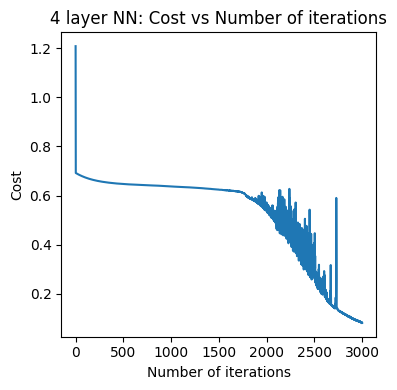

In [9]:
# Predictions for train and test with the four layer NN.
predictions_train = four_layer_NN.predict(train_X)
predictions_test = four_layer_NN.predict(test_X)

# Select the first row of each array to make them 1D. Calculate accuracy for 4 layer NN
accuracy_train = accuracy_score(predictions_train[0], train_y[0])
accuracy_test = accuracy_score(predictions_test[0], test_y[0])

print(f"{len(layers_dims) - 1} layer NN: \nAccuracy_train: {100 * accuracy_train:.2f}% \nAccuracy_test: {100 * accuracy_test:.2f}%")

# Plot costs vs iterations
plt.plot(costs)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("4 layer NN: Cost vs Number of iterations")
plt.tight_layout()
plt.show()

# We can observe there is a large difference between our training and test set error. This means our model
# Currently has high variance (overfitting). To try to combat this, we can try and accumulate more data,
# or try regularization.

In [10]:
# Function to create an L-layer neural network with L2 and dropout regularization
def neural_network_reg(X, Y, layers_dims,
                       lamda=0, keep_prob=1, learning_rate = 0.0075,
                       num_iterations = 3000, print_cost=False, reg=False):

    np.random.seed(1) # Define np seed for reproducible results.

    NN = neural_network.NeuralNet(layers_dims) # Create NN instance, which initializes parameters.

    costs = [] # Collection of costs for plotting.

    # Repeat forward prop, back prop, and gradient descent num_iterations times.
    for i in range(num_iterations):

        # Extract prediction from forward prop and caches from each layer.
        AL, caches = NN.forward_propagation_with_dropout(X, keep_prob)

        # Use the prediction to compute the cost.
        cost = NN.compute_cost_reg(AL, Y, lamda)

        # Perform back prop.
        grads = NN.backward_propagation_with_dropout(AL, Y, caches, keep_prob, lamda, reg)

        # Update parameter using gradient descent.
        NN.update_parameters(grads, learning_rate)

        # Append cost to costs array for each iteration
        costs.append(cost)

        # Print cost per 500 iterations and for last iteration if print_cost is true.
        if (i % 500 == 0 or i == num_iterations - 1) and print_cost == True:
            print(f"Cost after iteration {i}: {cost}")

    return costs, NN

In [11]:
# Set structure for the 4 layer NN.
layers_dims = [12288, 20, 7, 5, 1]

# Train model.
costs, four_layer_NN_reg = neural_network_reg(train_X, train_y, layers_dims,
                                              lamda=0.4, keep_prob=0.9,
                                              print_cost = True, reg = True)

Cost after iteration 0: 1.3363956407504674
Cost after iteration 500: 0.7133243064748825
Cost after iteration 1000: 0.6114794757911202
Cost after iteration 1500: 0.3263759060098015
Cost after iteration 2000: 0.21516703390282282
Cost after iteration 2500: 0.1541758841485032
Cost after iteration 2999: 0.15980388508192295


4 layer NN with reg: 
Accuracy_train: 100.00% 
Accuracy_test: 84.00%


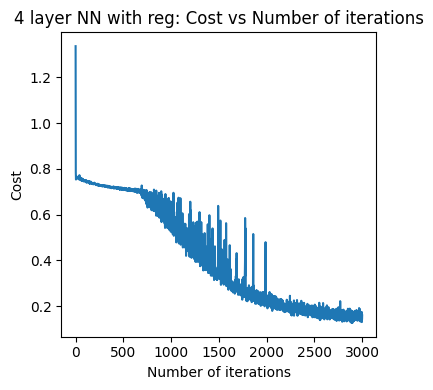

In [12]:
# Calculate predictions for model.
predictions_train = four_layer_NN_reg.predict(train_X)
predictions_test = four_layer_NN_reg.predict(test_X)

# Calculate accuracy for model.
accuracy_train = accuracy_score(predictions_train[0], train_y[0])
accuracy_test = accuracy_score(predictions_test[0], test_y[0])

print(f"{len(layers_dims) - 1} layer NN with reg: \nAccuracy_train: {100 * accuracy_train:.2f}% \nAccuracy_test: {100 * accuracy_test:.2f}%")

# Plot costs vs iterations
plt.plot(costs)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("4 layer NN with reg: Cost vs Number of iterations")
plt.tight_layout()
plt.show()

In [13]:
# By using dropout and l2 regularization we have managed to increase the test_accuracy slightly.
# To further improve on this we could do a hyperparameter search over the learning rate, keep_prob, and lamda value
# to find a more optimal configuration of these parameters. We observe the cost is very noisy, to dampen
# these oscillations we can use optimization techniques like learning rate decay or Adam optimization.

In [14]:
# Function to create an L-layer neural network with L2 and dropout regularization that uses the Adam optimizer.
def neural_network_reg_adam(X, Y, layers_dims,
                            lamda=0, keep_prob=1, beta_1=0.9,
                            beta_2=0.999, learning_rate = 0.0075, num_iterations = 2000,
                            print_cost=False, reg=False):

    np.random.seed(1) # Define np seed for reproducible results

    NN = neural_network.NeuralNet(layers_dims) # Create NN instance, which initializes parameters.

    costs = [] # Collection of costs for plotting

    # Repeat forward prop, back prop, and gradient descent num_iterations times.
    for i in range(num_iterations):
        t = i + 1
        # Extract prediction from forward prop and caches from each layer.
        AL, caches = NN.forward_propagation_with_dropout(X, keep_prob)

        # Use the prediction to compute the cost
        cost = NN.compute_cost_reg(AL, Y, lamda)

        # Perform back prop
        grads = NN.backward_propagation_with_dropout(AL, Y, caches, keep_prob, lamda, reg)

        # Update parameter using Adam optimization.
        NN.update_parameters_adam(grads, learning_rate, t, beta_1, beta_2)

        # Append cost to costs array for each iteration
        costs.append(cost)

        # Print cost per 500 iterations and for last iteration if print_cost is true
        if (i % 500 == 0 or i == num_iterations - 1) and print_cost == True:
            print(f"Cost after iteration {i}: {cost}")
            costs.append(cost)

    return costs, NN

In [15]:
# Set structure for the 4 layer NN
layers_dims = [12288, 20, 7, 5, 1]

# Train model.
costs, four_layer_NN_reg_adam = neural_network_reg_adam(train_X, train_y, layers_dims,
                                                        lamda=0.0008, keep_prob=0.9,
                                                        beta_1=0.9, beta_2=0.999, learning_rate = 0.00005,
                                                        print_cost=True, reg=True)

Cost after iteration 0: 1.2661729845409995
Cost after iteration 500: 0.5985790532733838
Cost after iteration 1000: 0.4806575932217139
Cost after iteration 1500: 0.4617297991324054
Cost after iteration 1999: 0.4387438885154836


4 layer NN with reg and Adam: 
Accuracy_train: 100.00% 
Accuracy_test: 86.00%


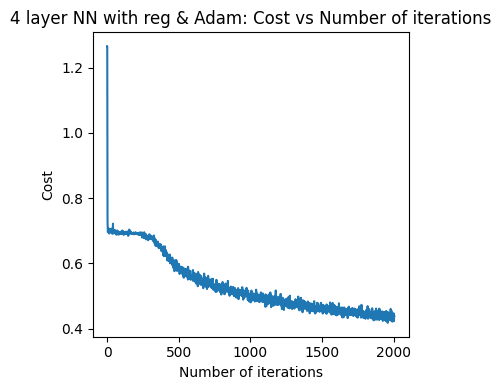

In [16]:
# Calculate predictions for model.
predictions_train = four_layer_NN_reg_adam.predict(train_X)
predictions_test = four_layer_NN_reg_adam.predict(test_X)

# Calculate accuracy for model.
accuracy_train = accuracy_score(predictions_train[0], train_y[0])
accuracy_test = accuracy_score(predictions_test[0], test_y[0])

print(f"{len(layers_dims) - 1} layer NN with reg and Adam: \nAccuracy_train: {100 * accuracy_train:.2f}% \nAccuracy_test: {100 * accuracy_test:.2f}%")

# Plot costs vs iterations
plt.plot(costs)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("4 layer NN with reg & Adam: Cost vs Number of iterations")
plt.tight_layout()
plt.show()

In [17]:
# By reducing the number of iterations (another form of regularization called early stopping)
# and implementing Adam optimization we have managed to squeeze an extra 2% from the model.
# Too further improve the model we could perform hyperparameter tuning to find a more optimal config
# of hyperparameters, we could collect more data, or create our own using data augmentation. We could
# also improve the speed of our algorithm by using Adam on mini-batches of our training data instead
# of our entire dataset at once. We could also use batch-norm to further improve learning speed whilst
# increasing the stability of our network by giving the NN the flexibility to change the mean and variance
# of the neurons.

In [18]:
# Function to create a L-layer neural network with L2 and dropout regularization that uses the Adam optimizer
# and implements batch-norm
def neural_network_reg_adam_batch_norm(X, Y, layers_dims,
                                       lamda=0, keep_prob=1, beta_1=0.9, beta_2=0.999,
                                       learning_rate = 0.0075, num_epochs = 155,
                                       print_cost=False, reg=False):

    np.random.seed(1) # Define np seed for reproducible results

    NN = neural_net_optimized.NeuralNetOptimized(layers_dims) # Create NN instance, which initializes parameters.

    costs = [] # Collection of costs for plotting

    t = 0
    # Repeat forward prop, back prop, and Adam optimization num_epochs times.
    for i in range(num_epochs):
        # Create mini_batches out of our X and Y datasets.
        mini_batches = NN.create_mini_batches(X, Y, mini_batch_size=64)
        epoch_cost = 0

        # Iterate through each mini_batch
        for mini_batch in mini_batches:
            mini_batch_X, mini_batch_Y = mini_batch

            # Update t to reflect minibatch t.
            t = t + 1

            # Extract prediction from forward prop and caches from each layer.
            AL, caches = NN.forward_propagation_with_dropout(mini_batch_X, keep_prob)

            # Use the prediction to compute the cost
            cost = NN.compute_cost_reg(AL, mini_batch_Y, lamda)

            # Perform back prop
            grads = NN.backward_propagation_with_dropout(AL, mini_batch_Y, caches, keep_prob, lamda, reg)

            # Update parameter using Adam optimization.
            NN.update_parameters_adam(grads, learning_rate, t, beta_1, beta_2)

            # Epoch cost is the sum of all mini-batch costs for current epoch
            epoch_cost += cost

        # Calculate the average cost over the mini-batches for one epoch
        avg_cost = epoch_cost / len(mini_batches)
        costs.append(avg_cost)

        # Print cost per 100 epochs and for last epoch if print_cost is true.
        if (i % 100 == 0 or i == num_epochs - 1) and print_cost == True:
            avg_cost = epoch_cost / len(mini_batches)
            print(f"Cost after epoch {i}: {avg_cost}")

    return costs, NN

In [19]:
# Set structure for the 4 layer NN
layers_dims = [12288, 20, 7, 5, 1]

# Train NN with L2 reg, Adam, and batch-norm.
costs, four_layer_NN_reg_batch = neural_network_reg_adam_batch_norm(train_X, train_y, layers_dims,
                                                        lamda=2.71, keep_prob=1,
                                                        beta_1=0.9, beta_2=0.999, learning_rate = 0.0005009,
                                                        print_cost=True, reg=True)

Cost after epoch 0: 3.40554710288063
Cost after epoch 100: 1.041952239860188
Cost after epoch 154: 0.8400026582136659


4 layer NN with reg, Adam, and batch-norm: 
Accuracy_train: 94.74% 
Accuracy_test: 88.00%


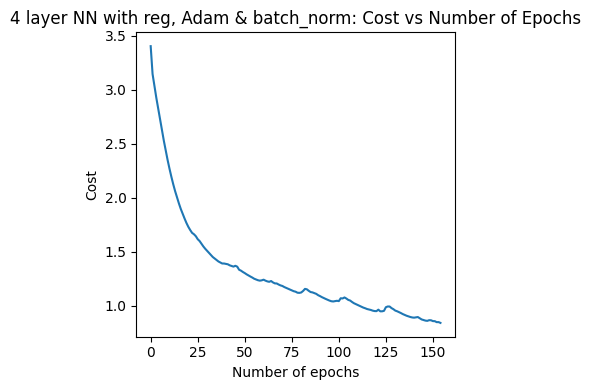

In [20]:
# Calculate predictions for model.
predictions_train = four_layer_NN_reg_batch.predict(train_X)
predictions_test = four_layer_NN_reg_batch.predict(test_X)

# Calculate accuracy for model.
accuracy_train = accuracy_score(predictions_train[0], train_y[0])
accuracy_test = accuracy_score(predictions_test[0], test_y[0])

print(f"{len(layers_dims) - 1} layer NN with reg, Adam, and batch-norm: \nAccuracy_train: {100 * accuracy_train:.2f}% \nAccuracy_test: {100 * accuracy_test:.2f}%")

# Plot costs vs iterations.
plt.plot(costs)
plt.xlabel("Number of epochs")
plt.ylabel("Cost")
plt.title("4 layer NN with reg, Adam & batch_norm: Cost vs Number of Epochs")
plt.tight_layout()
plt.show()

In [21]:
# Using batch-norm with mini-batches with adam and L2 regularization gave an additional 2% training accuracy.
# Not only did it improve the performance of our model on the test set, it also sped up training drastically,
# Without batch-norm, training took approximately 1 minute 30 seconds to give a good result, conversely, the batch-norm
# implementation not only gave a better result, but also took only approximately 9 seconds to give a good result.
# For training models on small datasets, this boost may not seem very significant, but for larger models, this
# speed boost could be the difference between training a model for months to training a model in weeks.

# We can observe how the oscillations of the cost function decreased when we implemented Adam and batch-norm.
# Adam decreases the oscillations by using a combination of RMSprop and momentum which averages out the gradients
# which smoothes out the steps when we update our parameters, which dampens the oscillations. Batch-norm normalizes
# the inputs to each layer, this creates a smoother field for the optimizer to traverse, leading to dampened
# oscillations. Batch-norm is also used with mini-batches of the training data, when we average over the
# mini-batches, this gives a less noisy curve. If we were to plot the cost for each mini-batch, we would get
# a much noisier curve, since each mini-batch would give us slightly different information and point us in
# a zig-zag like direction.

# To improve model performance, we could try: hyperparameter tuning to try and achieve an even more optimized configuration
# of the hyperparameters, overfitting is still present (although at a much lower rate than at which we started), so we could try
# increase the regularization or collect more data, we can also observe that our training accuracy also dropped, to improve this
# we could increase the depth of our NN or add more neurons per layer.